# E3. 카메라 스티커앱 만들기 첫걸음

1. 이미지 분석
    1. 이미지 읽기
    2. 얼굴 영역 검출
    3. 랜드마크 검출
2. 왕관 씌우기
    1. 왕관 이미지 불러오기
    2. 위치 정하기
    3. 왕관 이미지 변형
    4. 이미지 합치기
    5. addWeights로 왕관 합치기
3. 고양이 수염 붙이기
    1. 수염 이미지 불러오기
    2. 위치 정하기
    3. 수염 이미지 변형
    4. 이미지 합치기
4. 변수에 따른 영향 살펴보기

# 1. 이미지 분석

## 1 - A. 이미지 읽기

In [114]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

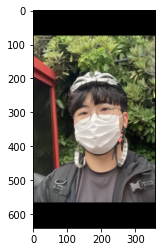

In [115]:
my_image_path = './images/image.jpeg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (360, 640))    # 640x360의 크기로 Resize
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_rgb.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_show)
plt.show()

## 1 - B. 얼굴 영역 검출

rectangles[[(115, 253) (270, 408)]]


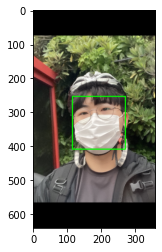

In [116]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_show)
plt.show()

## 1 - C. 랜드마크 검출

In [117]:
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    w = dlib_rect.width()
    h = dlib_rect.height()
    print(type(points))
print(len(list_landmarks[0]))

<class '_dlib_pybind11.full_object_detection'>
68


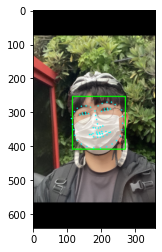

In [118]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show)
plt.show()

# 2. 왕관 씌우기

## 2 - A. 왕관 이미지 불러오기

(156, 156, 3)


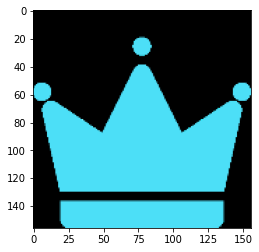

In [119]:
sticker_path = './images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

## 2 - B. 위치 정하기

왕관은 머리위에 있어야 하지 않겠는가, 우리가 구한 landmark에선 머리의 끝위치를 알려주지 않는다. 대신에 얼굴의 중앙에 위치한 코와 얼굴이라 인식한 부분의 width, height를 이용해 머리 윗부분을 찾아내려 한다. <br/>
landmark에서 30번째 인덱스가 코의 위치를 가리킨다고 한다. 제대로 코를 찍었는지 확인해보는 과정이 꼭 필요하다!! <br/>
코에 빨간점을 찍을 것이다.

(188, 365)


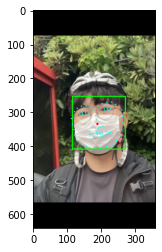

In [120]:
print(point)
for landmark in list_landmarks:
    point = landmark[30]
    cv2.circle(img_show, point, 2, (255, 0, 0), 2) # yellow

plt.imshow(img_show)
plt.show()

내가 마스크를 쓰고있어서 코를 제대로 인식못할까 걱정했는데, 생각보다 괜찮아서 다음과정으로 넘어가려한다.

In [121]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = dlib_rect.width()
    h = dlib_rect.height()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(188, 334)
(x,y) : (188,256)
(w,h) : (156,156)


In [122]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (110,100)


사실 여기서 아무리 생각해도 노드에서 왜 이런식으로 계산했는지 이해가 되지 않는다. 이해가 되지 않는 경우는 3가지다.
1. 코에 해당되는 landmark 30번 인덱스의 x, y 좌표를 저장하지 않고 변수 y에 y좌표에서 얼굴영역의 height의 절반을 뺀 값을 넣었다.
2. 기존 노드에서 y 좌표를 계산할 때 width의 절반을 빼주었다. height의 절반을 빼주었어야 한다.
3. refined_x는 잘 구했다고 생각한다. 하지만 refined_y를 구하는 과정이 너무 직관적이지 못하다.

## 2 - C. 왕관 이미지 변형
머리가 이미지의 높은 곳에 있을 경우 왕관 이미지의 높이 수정해주지 않으면 영역을 넘어서기 때문에 오류가 날 수 있다.<br/> 왕관의 윗부분을 자르는 작업

In [123]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(156, 156, 3)


여기서도 문제가 있는데 `img_sticker = img_sticker[-refined_y:]` 노드에선 이렇게만 사용이 되었다. 하지만 이는 왕관의 넣을 공간의 시작위치의 y좌표 즉, 우리가 구한 refined_y가 범위를 벗어낫을 경우(refined_y<0)에만 시행해야 한다. 그렇지 않다면 당연히 쓸데없이 왕관의 이미지를 자르게 된다.

## 2 - D. 이미지 합치기

이때까지 `img_show` 의 이미지에 얼굴영역 표시하고 랜드마크 검출했었는데, 결과 이미지에 들어가는 내용들은 `img_rgb`에 저장하려한다.

In [124]:
sticker_area = img_rgb[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

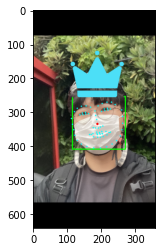

In [125]:
plt.imshow(img_show)
plt.show()

## 2 - E. addWeights로 왕관 합치기

앞서 기존의 이미지에 왕관 사진을 합성했다. 이는 `np.where` 를 이용해 img_sticker가 0인 부분, 그러니까 스티커의 테투리에 검정부분은 기존 이미지를 사용하고 0이 아닌 부분, 즉 왕관 이미지에 해당되는 부분은 왕관 이미지가 위치하도록 하였다. 그러니까 둘중 하나를 선택한 셈이다.

그런데 이러한 방법은 매우 번거롭다. 그리고 직관적이지 않다.<br/>
그래서 `sticker_area + img_sticker`를 하면 어떻게 될까?? <br/>

답은 특정 부분이 하얗게 변할 것이다. 왜냐하면 두 이미지를 덧셈을, 행렬 덧셈을 했으므로 합이 (255, 255, 255)를 초과하는 경우가 생길 수 있다. 이는 이미지에서 하얗게 표시된다.

이것은 적절히 않다.

그래서 이미지 간의 가중치를 정해 덧셈을 하는 `addWeigths`를 사용해보려 한다.

<br/>`img_show`는 이미 왕관이 씌여져 있어서 기존 이미지 `img_rgb`에다가 씌웠다~

In [131]:
img_rgb[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,sticker_area,cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.5, 0)).astype(np.uint8)

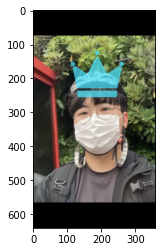

In [132]:
plt.imshow(img_rgb)
plt.show()

# 3. 고양이 수염 붙이기

    1. 수염 이미지 불러오기
    2. 위치 정하기
    3. 수염 이미지 변형
    4. 이미지 합치기

## 3 - A. 수염 이미지 불어오기

(156, 156, 3)


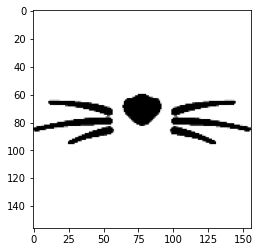

In [133]:
sticker_path = './images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

앞서 왕관이미지와 다르다는 것을 인지하고 넘어가자. 배경색과 스티커의 색깔에 차이가 있다.

## 3 - B. 위치 정하기

고양이 수염은 양 볼에 있어야 한다. 우리가 구한 landmark에서 볼의 위치를 알려주진 않는다. 대신에 적절한 위치의 landmark 점을 통해 볼의 위치를 찾아내보자. <br/> 이를위해 landmark의 인덱스와 위치를 알려주는 이미지를 보자 <br/>
![landmark](./assets/landmark.png)
<!-- landmark에서 30번째 인덱스가 코의 위치를 가리킨다고 한다. 제대로 코를 찍었는지 확인해보는 과정이 꼭 필요하다!! <br/>
코에 빨간점을 찍을 것이다. -->

내가 원하는 것은 볼 중앙의 위치이다. 볼은 2개다. 각각을 위해 다음의 Landmark Point를 사용하려 한다.<br/>
- 왼쪽 볼을 위해 2번, 36번, 48번, 30번
- 오른쪽 볼을 위해 14번, 45번, 54번, 30번

내 이미지에서 해당 위치를 잘 찾았는지 확인해보자

In [134]:
left = [2, 36, 48, 30]
right = [14, 45, 54, 30]

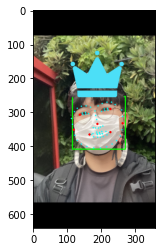

In [135]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        if idx in left:
            cv2.circle(img_show, point, 2, (255, 0, 0), 2) # red
        if idx in right:
            cv2.circle(img_show, point, 2, (255, 0, 0), 2) # red
plt.imshow(img_show)
plt.show()

잘 불러온 것을 확인할 수 있다. <br/>

다음으로 내가 필요한 것은 4개점의 중앙점과 그 범위의 width와 height이다.

전체 X점, Y점 리스트 만들기

In [136]:
landmarks = list_landmarks[0]
left_xs = [landmarks[index][0] for index in left]
left_ys = [landmarks[index][1] for index in left]

right_xs = [landmarks[index][0] for index in right]
right_ys = [landmarks[index][1] for index in right]

- 중앙점: 각 점들의 평균값
- width: 30번 점의 x 좌표 - 2번 점의 x 좌표
- height: 48번 점의 y 좌표 - 36번 점의 y 좌표

In [137]:
left_x = sum(left_xs)//len(left_xs)
left_y = sum(left_ys)//len(left_ys)

left_w = landmarks[30][0] - landmarks[2][0]
left_h = landmarks[48][1] - landmarks[36][1]

right_x = sum(right_xs)//len(right_xs)
right_y = sum(right_ys)//len(right_ys)

right_w = landmarks[14][0] - landmarks[30][0]
right_h = landmarks[54][1] - landmarks[45][1]


print(f"left_x: {left_x}, left_y: {left_y}, left_width: {left_w}, left_hieght: {left_h}")
print(f"right_x: {right_x}, right_y: {right_y}, right_width: {right_w}, left_hieght: {right_h}")

left_x: 152, left_y: 339, left_width: 69, left_hieght: 58
right_x: 225, right_y: 328, right_width: 74, left_hieght: 68


In [138]:
left_refined_x = left_x - left_w // 2  # left
left_refined_y = left_y - left_h // 2  # top

right_refined_x = right_x - right_w // 2  # left
right_refined_y = right_y - right_h // 2  # top
print ('(left_x,left_y) : (%d,%d)'%(left_refined_x, left_refined_y))
print ('(right_x,right_y) : (%d,%d)'%(right_refined_x, right_refined_y))

(left_x,left_y) : (118,310)
(right_x,right_y) : (188,294)


In [139]:
sticker_path = './images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (left_w,left_h))
print (img_sticker.shape)

(58, 69, 3)


In [140]:
img_sticker = img_sticker[-left_refined_y:]
sticker_area = img_show[left_refined_y:left_refined_y + img_sticker.shape[0], left_refined_x:left_refined_x+img_sticker.shape[1]]
img_rgb[left_refined_y:left_refined_y + img_sticker.shape[0], left_refined_x:left_refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

img_sticker = img_sticker[-right_refined_y:]
sticker_area = img_show[right_refined_y:right_refined_y + img_sticker.shape[0], right_refined_x:right_refined_x+img_sticker.shape[1]]
img_rgb[right_refined_y:right_refined_y + img_sticker.shape[0], right_refined_x:right_refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

`addWeights` 부분에서 대략적으로 설명을 하긴 했지만 `np.where` 은 첫번째 인자로 조건식이 오고 두번째 인자로 조건이 참일때의 값, 세번째 인자로 조건이 거짓일때의 값을 줘야한다. <br/>
왕관의 이미지는 배경이 검정색이고 왕관부분의 색이 있었다. 하지만 고양이 수염 이미지의 경우 배경이 흰색이고 수염이 검정색이다. <br/>
그래서 `0 <-> 255`의 변화가 있음을 인지하자. 이와같이 첫번째 인자의 값을 바꿔도 되고 두번째 인자와 세번째 인자 순서를 바꿔줘도 된다.

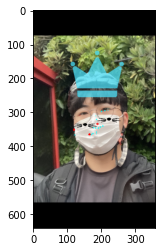

In [141]:
plt.imshow(img_rgb)
plt.show()

---

# 4. 변수에 따른 영향 살펴보기

얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보기위해서 웹캠을 통해 실시간으로 테스트해보았다.

<필요한 detector 객체 및 함수정의>

In [142]:
detector = dlib.get_frontal_face_detector()   #- detector 선언
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 왕관 이미지
sticker_path = './images/king.png'
king_sticker = cv2.imread(sticker_path)

# 고양이 수염 이미지
sticker_path = './images/cat-whiskers.png'
cat_sticker = cv2.imread(sticker_path)


def face_detection_landmark(image):
    faces = detector(image, 1)   #- (image, num of img pyramid)
    list_landmarks = []
    for face in faces:
        l = face.left()
        t = face.top()
        r = face.right()
        b = face.bottom()

        cv2.rectangle(image, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

        points = landmark_predictor(image, face)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    return image, faces, list_landmarks

def draw_emoji(image, faces, list_landmarks):
    # ------------------king----------------- #
    
    for face, landmark in zip(faces, list_landmarks):
        
        x = landmark[30][0]
        y = landmark[30][1] - face.width()//2
        w = face.width()
        h = face.height()

    img_sticker = cv2.resize(king_sticker, (w,h))

    refined_x = x - w // 2  # left
    refined_y = y - h       # top
    
    # 얼굴이 화면 밖으로 이동시
    if refined_x < 0:
        return image
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
    else:
        img_sticker = img_sticker[refined_y:]
    if refined_y < 0:
        refined_y = 0
        
    sticker_area = image[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    image[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    
    # ------------------cat----------------- #
    
    left = [2, 36, 48, 30]
    right = [14, 45, 54, 30]
    
    landmarks = list_landmarks[0]
    left_xs = [landmarks[index][0] for index in left]
    left_ys = [landmarks[index][1] for index in left]

    right_xs = [landmarks[index][0] for index in right]
    right_ys = [landmarks[index][1] for index in right]
    
    left_x = sum(left_xs)//len(left_xs)
    left_y = sum(left_ys)//len(left_ys)

    left_w = landmarks[30][0] - landmarks[2][0]
    left_h = landmarks[48][1] - landmarks[36][1]

    right_x = sum(right_xs)//len(right_xs)
    right_y = sum(right_ys)//len(right_ys)

    right_w = landmarks[14][0] - landmarks[30][0]
    right_h = landmarks[54][1] - landmarks[45][1]


    left_refined_x = left_x - left_w // 2  # left
    left_refined_y = left_y - left_h // 2  # top

    right_refined_x = right_x - right_w // 2  # left
    right_refined_y = right_y - right_h // 2  # top
    
    sticker_path = './images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (left_w,left_h))
    img_sticker = img_sticker[-left_refined_y:]
    sticker_area = image[left_refined_y:left_refined_y + img_sticker.shape[0], left_refined_x:left_refined_x+img_sticker.shape[1]]
    image[left_refined_y:left_refined_y + img_sticker.shape[0], left_refined_x:left_refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    img_sticker = img_sticker[-right_refined_y:]
    sticker_area = image[right_refined_y:right_refined_y + img_sticker.shape[0], right_refined_x:right_refined_x+img_sticker.shape[1]]
    image[right_refined_y:right_refined_y + img_sticker.shape[0], right_refined_x:right_refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    return image



<카메라 스트리밍>

In [144]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    
    if ret:
        image, faces, list_landmarks = face_detection_landmark(frame)
        if faces:
            image = draw_emoji(image, faces, list_landmarks)
        
        cv2.imshow('A',image)

        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        if key == ord('s'):
            cv2.imwrite('suwan.png', image)
            
            
cap.release()
cv2.destroyAllWindows()

코드에 문제가 있다. 새롭게 만든 4개의 변수 `left_refined_x`, `left_refined_y`, `right_refined_x`, `right_refined_y`는 고양이 수염의 좌측상단의 좌표를 의미한다. 그리고 거기에 width와 height를 더한값은 고양이 수염의 우측하단 좌표를 의미한다. 이 좌표들이 음수값을 가지게 되면(얼굴이 왼쪽 혹은 오른쪽 끝에서 인식이 되는 경우) 오류가 난다. 이는 왕관을 씌우는 예제에서 refiend_y 값이 음수면 0으로 바꿔주는 것과 같은 원리로 오류를 해결할 수 있다.

![demo](./assets/video.gif)

# 결론

`dlib`의 `get_frontal_face_detector()`를 사용해서 얼굴인식을 하고 인식된 결과는 `landmark_predictor` 함수를 통해 68개의 점을 찾아 다양한 그림을 그렸다. 그런데 얼굴인식이 되지 않는다면 당연히 랜드마크를 찾을 수 없고 그림을 그릴 수 없다. 

동영상에 볼 수 있듯이 조명에 따라서는 크게 결과가 달라지지 않지만, 얼굴각도가 조금이라도 틀어지면 얼굴인식을 전혀 못했다. 또 촬영거리는 바로 앞 30cm 거리에서 1m 넘는 거리까지 움직였음에도 얼굴을 인식하는 모습을 보였다. 하지만 매우 띄엄띄엄 얼굴인식을 하였기 때문에 얼굴인식의 결과가 좋지 않다고 이야기할 수 있을 것 같다.

처음 이미지를 선택했는데 얼굴인식이 잘 되었고 얼굴이 사진의 중앙에 위치했기에 문제없이 과정을 잘 수행했었다. 하지만, 실제로 카메라에 적용을 해봤는데, 버그를 손쉽게 발견할 수 있었다. 이는 실제 서비스에 적용 시 얼마나 정교하게 코드를 작성해야 함을 보여준다.